In [1]:
import numpy as np
import cv2
import os
from matplotlib import pyplot as plt
import pytesseract
import editdistance
import re
from pdf2image import convert_from_path
from statistics import mean
import copy
import sys
import base64
from datetime import datetime
from IPython.display import clear_output
%run find_similar_docs.ipynb


ERROR:root:File `'find_similar_docs.ipynb.py'` not found.


In [2]:
def load_image(input_path):
#     input_path = "/home/zeus/Downloads/yieldstreet/For_Fuse3/W2/W2_example11.pdf"
    if input_path.endswith(('.pdf','.PDF')):
        pages = convert_from_path(input_path)  
        page = pages[0] # only selects first image for now
        img = np.asarray(page)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
#         print(img.shape)
    else:
        img = cv2.imread(input_path, 0)
#         print(img.shape)
#     print("image shape",img.shape)
    return img

In [24]:
def get_content_image(img):
    content_image = copy.deepcopy(img)
    content_image = cv2.cvtColor(content_image, cv2.COLOR_BGR2GRAY)
    _,thresh = cv2.threshold(content_image,1,255,cv2.THRESH_BINARY)
    #     cv2.imwrite("./rotation_intermediate/AfterThresholdImage.jpg", img)
    im2, contours,hierarchy = cv2.findContours(thresh,cv2.RETR_EXTERNAL,cv2.CHAIN_APPROX_SIMPLE)
    contour_area = [cv2.contourArea(c) for c in contours]
    cnt = contours[np.argmax(contour_area)]
    x,y,w,h = cv2.boundingRect(cnt)
#     cv2.imwrite(os.path.join(INTERMEDIATE_FOLDER,"content_image.jpg"), 
#                 cv2.rectangle(cv2.cvtColor(content_image, cv2.COLOR_GRAY2BGR),(x,y),(x+w,y+h),(0,0,255),5))

    content_image = img[y:y+h, x:x+w,:]
    return content_image

In [4]:
def find_required_rotation_angle(original_img):
    QUANTIZATION_GAP = 1
    img = copy.deepcopy(original_img)
#     cv2.imwrite("./rotation_intermediate/Original.jpg", img)
    
    
    '''Bluring and Thresholding'''
    blur = cv2.GaussianBlur(copy.deepcopy(img),(3,3),0)
#     cv2.imwrite("./rotation_intermediate/AfterBluringImage.jpg", img)
    
    threshold_value = get_thresholding_value(blur)
    img_bin = cv2.threshold(blur, threshold_value, 255, cv2.THRESH_BINARY| cv2.THRESH_OTSU)[1]
#     cv2.imwrite("./rotation_intermediate/AfterThresholdFirstImage.jpg", img)
    
    
    '''Detect Contours'''
    _, contours, _ = cv2.findContours(copy.deepcopy(img_bin), cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
#     cv2.imwrite("./rotation_intermediate/AfterFirstContour.jpg", img)
    
    
    
    angles_count = {}
    for count, c in enumerate(contours):
        
        rect = cv2.minAreaRect(c)
        box = cv2.boxPoints(rect)
        
        w = int(rect[1][0])
        h = int(rect[1][1])
        y = int(rect[0][0])
        x = int(rect[0][1])
        angle = rect[2]
        
        if angle > 45:
            angle -= 90
            tmp = w
            w = h
            h = tmp
        elif angle < -45:
            angle += 90
            tmp = w
            w = h
            h = tmp
        elif abs(angle)==0:
            angle=0

#If the box height is greater then 20, widht is >80, then only save it as a box in "cropped/" folder.
        if (w > 80 and h > 20) and w < img.shape[1]//1.5 and h < img.shape[0]//4:
            quantized_angle = str((angle//QUANTIZATION_GAP)*QUANTIZATION_GAP)
            if  quantized_angle in angles_count.keys():
                angles_count[quantized_angle] += 1
            else:
                angles_count[quantized_angle] = 1
    
    if angles_count:
        required_rotation = int(float(max(angles_count, key=angles_count.get)))
    else:
        required_rotation = 0
        print("No boxes found")
    print(angles_count)
    print("Angle: ", required_rotation)
    return required_rotation

In [5]:
def correct_orientation(original_img, folder):
    
    required_angle = find_required_rotation_angle(original_img)
    print(required_angle)
    if abs(required_angle) >2:
        ROTATION_FLAG = True
        img = rotate_image(original_img, required_angle)
        img = get_content_image(img)
    else:
        ROTATION_FLAG = False
        img = original_img
    
    return img, ROTATION_FLAG
            
    
    

In [6]:
def rotate_image(mat, angle):
    """
    Rotates an image (angle in degrees) and expands image to avoid cropping
    """
    if abs(angle) < 1:
        return mat
    image_center = (mat.shape[1]/2, mat.shape[0]/2)
    height, width = mat.shape[:2] # image shape has 3 dimensions

    rotation_mat = cv2.getRotationMatrix2D(image_center, angle, 1.)
#     print("rotation_mat: ", rotation_mat)

    # rotation calculates the cos and sin, taking absolutes of those.
    abs_cos = abs(rotation_mat[0,0]) 
    abs_sin = abs(rotation_mat[0,1])

    # find the new width and height bounds
    bound_w = int(height * abs_sin + width * abs_cos)
    bound_h = int(height * abs_cos + width * abs_sin)

    # subtract old image center (bringing image back to origo) and adding the new image center coordinates
    rotation_mat[0, 2] += bound_w/2 - image_center[0]
    rotation_mat[1, 2] += bound_h/2 - image_center[1]
#     print("rotation_mat: ", rotation_mat)
#     print("Image Center: ", image_center)
#     print("Angle: ", angle)
    
#     print("rotation_mat: ", rotation_mat)
#     print("bound_w: ", bound_w)
#     print("bound_h: ", bound_h)

    # rotate image with the new bounds and translated rotation matrix
    rotated_mat = cv2.warpAffine(mat, rotation_mat, (bound_w, bound_h))
    return rotated_mat

/media/raj/new/Driving_license/Data/jpgfile/IMG_20190115_0025.jpg
[[22.22222222 14.22222222  6.88888889 ... 33.55555556 42.88888889
  54.        ]
 [14.22222222  6.88888889  6.88888889 ... 60.22222222 60.22222222
  60.22222222]
 [ 8.22222222  8.22222222  4.66666667 ... 28.22222222 28.22222222
  28.22222222]
 ...
 [14.         14.          6.22222222 ...  0.          0.
   0.        ]
 [14.         14.          6.22222222 ...  0.          0.
   0.        ]
 [14.         14.          6.22222222 ...  0.          0.
   0.        ]]
(3507, 2480)
(3507, 2480, 3)
(3507, 2480)


KeyboardInterrupt: 

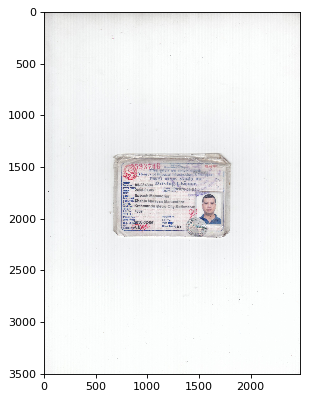

In [112]:
FOLDER_PATH = "/media/raj/new/Driving_license/Data/jpgfile"
INTERMEDIATE_FOLDER = "/media/raj/new/Driving_license/tmp"
for file in os.listdir(FOLDER_PATH):
    file_path = os.path.join(FOLDER_PATH, file)
    print(file_path)
    
    img = cv2.imread(file_path)
    plt.figure(num=None, figsize=(8, 6), dpi=80, facecolor='w', edgecolor='k')
    plt.imshow(img[:,:,::-1])
    cv2.imwrite(os.path.join(INTERMEDIATE_FOLDER, "original_image.jpg"), img)
    img_gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    
#     black_rgb = np.logical_and(np.abs(img[:,:,0]-img[:,:,1]) < 100,
#                               np.logical_and(np.abs(img[:,:,1]-img[:,:,2]) < 100,
#                             np.logical_and(np.abs(img[:,:,2]-img[:,:,0]) < 100, img_gray[:,:] < 0)))

    black_rgb = np.logical_and(np.var(img, axis=2)<30,img_gray[:,:] < 200)

    print(np.var(img, axis=2))
    print(black_rgb.shape)
    print(img.shape)
    save_img = np.ones(tmp_img[:,:,2].shape)*255
    save_img[black_rgb]=0
    cv2.imwrite(os.path.join(INTERMEDIATE_FOLDER,"rgb_black.jpg"), save_img)
    
    
    
    
    
    tmp_img = cv2.cvtColor(img, cv2.COLOR_BGR2HSV)
#     print(tmp_img[:,:,2])
    cv2.imwrite(os.path.join(INTERMEDIATE_FOLDER,"hue_image.jpg"), tmp_img[:,:,0])
    cv2.imwrite(os.path.join(INTERMEDIATE_FOLDER,"saturation_image.jpg"), tmp_img[:,:,1])
    cv2.imwrite(os.path.join(INTERMEDIATE_FOLDER,"value_image.jpg"), tmp_img[:,:,2])
    
#     print(min(tmp_img[:,:,2].ravel()))
#     print(tmp_img[:,:,2])
#     print(tmp_img[:,:,2]>30)
    print((tmp_img[:,:,2] > 160).shape)
    blur = cv2.GaussianBlur(img_gray,(3,3),0)
    img_bin = cv2.threshold(blur, 127, 255, cv2.THRESH_BINARY)[1]
    cv2.imwrite(os.path.join(INTERMEDIATE_FOLDER,"threshold.jpg"), img_bin)
    
    colorless_flag = tmp_img[:,:,1] < 35
    low_intensity_flag = tmp_img[:,:,2] < 200
    black_region_flag = np.logical_and(colorless_flag, low_intensity_flag)
    
    save_img = np.ones(tmp_img[:,:,2].shape)*255
    save_img[colorless_flag]=0
    cv2.imwrite(os.path.join(INTERMEDIATE_FOLDER,"colorless.jpg"), save_img)
    
    save_img = np.ones(tmp_img[:,:,2].shape)*255
    save_img[low_intensity_flag]=0
    cv2.imwrite(os.path.join(INTERMEDIATE_FOLDER,"low_intensity.jpg"), save_img)
        
    save_img = np.ones(tmp_img[:,:,2].shape)*255
    save_img[black_region_flag]=0
    cv2.imwrite(os.path.join(INTERMEDIATE_FOLDER,"black_region.jpg"), save_img)
    
    save_img = np.ones(tmp_img[:,:,2].shape)*255
    save_img[black_region_flag]=tmp_img[:,:,2][black_region_flag]
    tmp_img[:,:,2] = save_img
    cv2.imwrite(os.path.join(INTERMEDIATE_FOLDER,"final.jpg"), cv2.cvtColor(tmp_img,cv2.COLOR_HSV2BGR))
    
    
    input()
    clear_output()

### End